##  Random forest Classification

#### imports

In [35]:
import os
import sys
import warnings

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

from sklearn.metrics import confusion_matrix
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

In [61]:
warnings.filterwarnings('ignore')

SCRIPT_DIR = os.path.abspath('')
sys.path.append(os.path.dirname(SCRIPT_DIR))


#### Get data

In [37]:
from util.file import get_absolute_file_path

relative_path = "../data/WineData2.csv"
file_path = get_absolute_file_path(relative_path)


In [62]:
spark = SparkSession \
    .builder \
    .appName("Random forest Classification") \
    .getOrCreate()

In [39]:
df = spark.read.format('csv') \
            .options(header='true', inferschema='true') \
            .load(file_path);
df.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [40]:
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



#### functions

In [41]:
def string_to_float(x: str) -> float:
    """Convert to float format."""
    return float(x)

In [42]:
def condition(r: int) -> str:
    """Get the condition as a string."""
    if (0<= r <= 4):
        label = "low"
    elif(4< r <= 6):
        label = "medium"
    else:
        label = "high"
    return label

#### UDF

In [43]:
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

df = df.withColumn("quality", quality_udf("quality"))

df.show(5,True)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4| medium|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8| medium|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [44]:
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: string (nullable = true)



#### Transform the dataset to DataFrame

In [45]:
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [46]:
transformed = transData(df)
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



#### Deal with Categorical Label and Variables

In [47]:
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows



In [48]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



#### Split the data to training and test data sets

In [49]:
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+---------------------------------------------------------+------+
|features                                                 |label |
+---------------------------------------------------------+------+
|[4.6,0.52,0.15,2.1,0.054,8.0,65.0,0.9934,3.9,0.56,13.1]  |low   |
|[4.9,0.42,0.0,2.1,0.048,16.0,42.0,0.99154,3.71,0.74,14.0]|high  |
|[5.0,0.4,0.5,4.3,0.046,29.0,80.0,0.9902,3.49,0.66,13.6]  |medium|
|[5.0,0.74,0.0,1.2,0.041,16.0,46.0,0.99258,4.01,0.59,12.5]|medium|
|[5.0,1.02,0.04,1.4,0.045,41.0,85.0,0.9938,3.75,0.48,10.5]|low   |
+---------------------------------------------------------+------+
only showing top 5 rows

+---------------------------------------------------------+------+
|features                                                 |label |
+---------------------------------------------------------+------+
|[4.7,0.6,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.6,12.9] |medium|
|[5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.7,0.75,14.0]|medium|
|[5.0,0.42,0.24,2.0,0.06,19.0,50.0,0.

#### Fit Random Forest Classification Model

In [50]:
rf = RandomForestClassifier(featuresCol='indexedFeatures', labelCol='indexedLabel')

#### Pipeline

In [51]:
labelConverter = IndexToString(inputCol="prediction",
                               outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [52]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [53]:
# Train model.
model = pipeline.fit(trainingData)

#### Make predictions

In [54]:
predictions = model.transform(testData)
predictions.select("features", "label", "predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.7,0.6,0.17,2.3...|medium|        medium|
|[5.0,0.38,0.01,1....|medium|          high|
|[5.0,0.42,0.24,2....|  high|          high|
|[5.0,1.04,0.24,1....|medium|        medium|
|[5.2,0.32,0.25,1....|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



#### Evaluation

In [55]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel",
    predictionCol="prediction",
    metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Error = {1.0 - accuracy}")

Test Error = 0.15610510046367854


#### Visualization

In [56]:
from util.visualization import plot_confusion_matrix

In [57]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = list(map(str, class_temp))
class_names

['medium', 'high', 'low']

In [58]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[517,   8,   0],
       [ 65,  29,   0],
       [ 27,   1,   0]])

Confusion matrix, without normalization
[[517   8   0]
 [ 65  29   0]
 [ 27   1   0]]


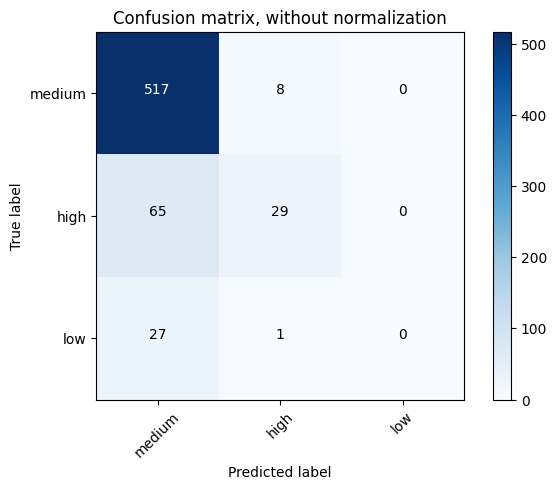

In [59]:
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.9847619  0.0152381  0.        ]
 [0.69148936 0.30851064 0.        ]
 [0.96428571 0.03571429 0.        ]]


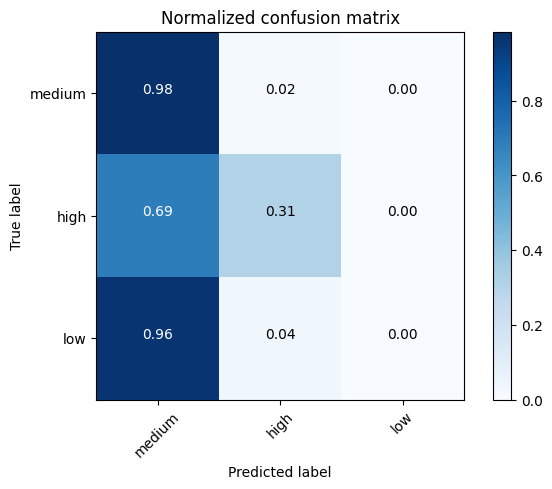

In [60]:
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()